#### Imports

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import pickle
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from tqdm import tqdm
from HRP_class import *
import os
from sklearn.preprocessing import StandardScaler

#### Load data

In [2]:
# Load train data
train = pl.read_csv('train.csv')

# Check available stocks for the different time_ids
stocks_per_time_id = dict()
unique_time_ids = train.select("time_id").unique().to_series().to_list()

for id in unique_time_ids:
    stocks_per_time_id[id] = train.with_columns(pl.col("time_id") == id).select("stock_id").unique().to_series().to_list()

# Pre-load all trades data for each stock into a dictionary
all_trade_data = {}

for stock in stocks_per_time_id[5]:  # all time_ids have the same stocks
    file = os.path.join(f"trade_train.parquet/stock_id={stock}", os.listdir(f"trade_train.parquet/stock_id={stock}")[0])
    all_trade_data[stock] = pl.read_parquet(file)

# Initialize a dictionnary that will contain for each time_id a dictionnary of trading books of the different stocks.
trading_books_per_id = {int(id): {} for id in unique_time_ids}

# Loop to fill the "trading_books_per_id" dictionnary
for id in tqdm(unique_time_ids):
    int_id = int(id)
    for stock in stocks_per_time_id[id]:
        # Use the pre-loaded data for the current stock
        trade_train_data = all_trade_data[stock]
        # Filter the data for the current time_id
        trading_book = trade_train_data.filter(pl.col('time_id') == int_id).clone()
        if trading_book.height > 3:
            # Store the filtered data in the result dictionary
            trading_books_per_id[int_id][stock] = trading_book

100%|██████████| 3830/3830 [02:16<00:00, 28.14it/s]


In [3]:
with open('unique_time_ids.pkl', 'wb') as file:
    pickle.dump(unique_time_ids, file)

### Choose 10 Stocks to invest in

#### **Step-by-Step Process to select the 10 Stocks to invest in:**

**1.Calculate Key Metrics for Each Stock**

For each stock, within each time_id, we compute the following metrics:

* **Average Return:** Measure of performance.
* **Volatility of Returns:** Measure of risk.
* **Average Trade Size:** Measure of liquidity.
* **Order Count:** Measure of market participation.

**2. Normalize the Metrics**

We normalize these metrics to bring them onto a common scale using min-max normalization.

**3. Compute Composite Score**

We combine the normalized metrics into a single composite score:

$$ Score = w_1* Average\_Return + w_2* Volatility\_of\_Return + w_3*Total\_Size + w_4*Order\_Count$$

**4. Aggregate Scores Across Time Periods**

We compute an overall score for each stock by averaging its scores across all time_ids.

**5. Rank Stocks and Select Top 10**

We rank the stocks based on their overall scores and select the top 10.

In [4]:
# Weights for each metric
weights = {
    'average_return': 0.4,
    'volatility': 0.2,
    'average_size': 0.2,
    'order_count': 0.2
}

def compute_metrics(df):
    df = df.with_columns((pl.col('price').pct_change().fill_nan(0)).alias('Return'))
    
    average_return = df['Return'].mean()
    volatility = df['Return'].std()
    average_size = df['size'].mean()
    order_count = df['order_count'].sum()
    
    return average_return, volatility, average_size, order_count

def normalize(series):
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

# Dictionary to hold aggregate scores
aggregate_scores = {stock: [] for stock in all_trade_data.keys()}

for time_id, stocks in tqdm(trading_books_per_id.items()):
    metrics = {metric: [] for metric in weights.keys()}
    
    for stock_id, df in stocks.items():
        avg_return, vol, avg_size, order_count = compute_metrics(df)
        
        metrics['average_return'].append(avg_return)
        metrics['volatility'].append(vol)
        metrics['average_size'].append(avg_size)
        metrics['order_count'].append(order_count)
    
    for metric in metrics.keys():
        metrics[metric] = normalize(pl.Series(metrics[metric]))
    
    for i, stock_id in enumerate(stocks.keys()):
        score = (
            weights['average_return'] * metrics['average_return'][i] +
            weights['volatility'] * (1 - metrics['volatility'][i]) + # Minimize volatility
            weights['average_size'] * metrics['average_size'][i] +
            weights['order_count'] * metrics['order_count'][i]
        )
        aggregate_scores[stock_id].append(score)

# Compute overall scores
overall_scores = {stock: np.mean(scores) for stock, scores in aggregate_scores.items()}

# Select the top 10 stocks
top_10_stocks = sorted(overall_scores, key=overall_scores.get, reverse=True)[:10]

print("Top 10 stocks to invest in are:", top_10_stocks)

100%|██████████| 3830/3830 [02:13<00:00, 28.70it/s]

Top 10 stocks to invest in are: [43, 69, 124, 29, 31, 50, 111, 32, 41, 47]


### **Optimal weights computation**

#### Prepare data

In [5]:
# Pre-load all order book data for each stock into a dictionary
all_book_data = {}

for stock in stocks_per_time_id[5]:  # all time_ids have the same stocks
    file = os.path.join(f"book_train.parquet/stock_id={stock}", os.listdir(f"book_train.parquet/stock_id={stock}")[0])
    all_book_data[stock] = pl.read_parquet(file)

#### Fill missing seconds in the order books

In [6]:
# Function to add the seconds that are not available in the order book
def fill_gaps(book_example):
    # Create a DataFrame with all seconds from 0 to 600
    all_seconds = pl.DataFrame({'seconds_in_bucket': range(601)}).with_columns(pl.col('seconds_in_bucket').cast(pl.Int16))
    # Perform a left join with the book_example DataFrame
    merged_df = all_seconds.join(book_example, on='seconds_in_bucket', how='left')
    # Forward fill the missing values
    filled_df = merged_df.fill_null(strategy="forward")
    return filled_df

#### Calculate Order book Statistics

In [7]:
# Compute the weighted average price (WAP)
def wap(order_book):
    order_book = order_book.with_columns([
        ((pl.col('bid_price1') * pl.col('ask_size1') + pl.col('ask_price1') * pl.col('bid_size1')) / 
         (pl.col('bid_size1') + pl.col('ask_size1'))).alias('wap')
    ])
    return order_book

# Calculate the log-returns
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

# Calculate the Bid Ask Spread
def bid_ask_spread(order_book):
    order_book = order_book.with_columns([
        (pl.col('ask_price1')/pl.col('bid_price1') - 1).alias('spread')
    ])
    return order_book

# Calculate the Mid Price
def mid_price(order_book):
    order_book = order_book.with_columns([
        ((pl.col('bid_price1') + pl.col('ask_price1')) / 2).alias('mid_price')
    ])
    return order_book

# Calculate the Order Imbalance
def order_imbalance(order_book):
    order_book = order_book.with_columns([
        ((pl.col('bid_size1') - pl.col('ask_size1')) / 
         (pl.col('bid_size1') + pl.col('ask_size1'))).alias('order_imbalance')
    ])
    return order_book

# Calculate the Market Depth
def market_depth(order_book):
    order_book = order_book.with_columns([
        (pl.col('bid_size1') + pl.col('ask_size1')).alias('depth')
    ])
    return order_book

# Calculate the Bid Ask Slope
def bid_ask_slope(order_book):
    order_book = order_book.with_columns([
        ((pl.col('ask_price2') - pl.col('ask_price1')) / pl.col('ask_size1') - 
         (pl.col('bid_price1') - pl.col('bid_price2')) / pl.col('bid_size1')).alias('bid_ask_slope')
    ])
    return order_book

#### Calculate the Realized Volatilities

In [8]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [9]:
# Fill the dictionnary processed_books that contains for each time_id a dictionnary 
# of order books for the different stocks.

processed_books = {int(id): {} for id in unique_time_ids}
returns_per_id_per_stock = {int(id): {} for id in unique_time_ids}

for id in tqdm(unique_time_ids):
    for stock in top_10_stocks:
        order_book = all_book_data[stock].filter(pl.col('time_id') == id).clone()
        # Fill gaps
        order_book = fill_gaps(order_book)

        # Add the Weighted average price column
        order_book = wap(order_book)

        # Add the log-returns
        order_book = order_book.with_columns([
            log_return(order_book['wap']).alias('log_return')
        ])

        # Drop rows with NaN values in the 'log_return' column
        order_book = order_book.drop_nulls(subset=['log_return'])

        # Add the Bid Ask Spread
        order_book = bid_ask_spread(order_book)
        
        # Add the Mid Price
        order_book = mid_price(order_book)

        # Add the Order Imbalance
        order_book = order_imbalance(order_book)
    
        # Add the Market Depth
        order_book = market_depth(order_book)

        # Add the Bid Ask Slope
        order_book = bid_ask_slope(order_book)
        
        processed_books[int(id)][stock] = order_book
        returns_per_id_per_stock[int(id)][stock] = order_book['log_return']

100%|██████████| 3830/3830 [03:04<00:00, 20.80it/s]


In [33]:
processed_books[5][43]

seconds_in_bucket,time_id,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,book_train.parquet/stock_id,wap,log_return,spread,mid_price,order_imbalance,depth,bid_ask_slope
i16,i16,f32,f32,f32,f32,i32,i32,i32,i32,i64,f64,f64,f32,f32,f64,i32,f64
1,5,1.000013,1.000039,0.999987,1.000065,355,200,1555,1100,43,1.00003,0.00011,0.000026,1.000026,0.279279,555,5.6658e-8
2,5,0.999987,1.000039,0.999961,1.000065,855,355,355,655,43,1.000024,-0.000006,0.000052,1.000013,0.413223,1210,4.2936e-8
3,5,1.000118,1.000144,1.000092,1.00017,355,400,855,55,43,1.00013,0.000106,0.000026,1.000131,-0.059603,755,-8.3111e-9
4,5,1.000196,1.000223,1.00017,1.000249,555,300,300,655,43,1.000213,0.000083,0.000026,1.00021,0.298246,855,4.0166e-8
5,5,1.000432,1.000458,1.000406,1.000485,400,400,880,1300,43,1.000445,0.000232,0.000026,1.000445,0.0,800,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
596,5,1.001375,1.001401,1.001349,1.001427,300,242,500,342,43,1.001389,0.000123,0.000026,1.001388,0.107011,542,2.1349e-8
597,5,1.001375,1.001401,1.001349,1.001427,542,142,1100,542,43,1.001396,0.000006,0.000026,1.001388,0.584795,684,1.3652e-7
598,5,1.00148,1.001506,1.001454,1.001532,100,142,842,442,43,1.001491,0.000095,0.000026,1.001493,-0.173554,242,-7.6378e-8


#### Convert the results into Pandas DataFrames to save them for future use

In [34]:
processed_books_copy = processed_books.copy()
returns_per_id_per_stock_copy = returns_per_id_per_stock.copy()

for id in tqdm(processed_books_copy.keys()):
    for stock, order_book in processed_books_copy[id].items():
        processed_books_copy[id][stock] = order_book.to_pandas()
        returns_per_id_per_stock_copy[id][stock] = order_book.to_pandas()["log_return"]

100%|██████████| 3830/3830 [01:54<00:00, 33.37it/s]


#### Save the prepared books as pkl

In [4]:
# Serialize (I already did it)
# with open('processed_books.pkl', 'wb') as file:
#     pickle.dump((processed_books_copy, returns_per_id_per_stock_copy), file)

# Deserialize (to load the objects)
with open('processed_books.pkl', 'rb') as file:
    (processed_books, returns_per_id_per_stock) = pickle.load(file)

In [12]:
import seaborn as sns

<Axes: >

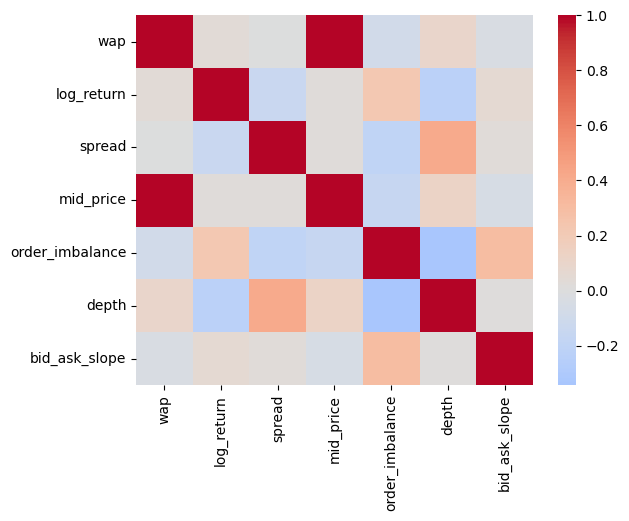

In [16]:
scaler = StandardScaler()
df = processed_books[11][43].iloc[:, -7:]
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
sns.heatmap(scaled_df.corr(), annot=False, cmap='coolwarm', center=0)

#### **Generate the correlation matrix and expected returns for each id**

#### Monte Carlo to generate the Expected returns

In [48]:
def monte_carlo_expected_returns(std, number_iterations):
    result_list = []
    for i in range(number_iterations):
        result_list.append(np.random.normal(0, std*np.sqrt(600), size=1))

    return np.mean(result_list)

#### Calculate the correlation and covariance matrices 

In [83]:
number_iterations = 1000
correlation_std_returns_per_id = {int(id): {} for id in unique_time_ids}
covariance_returns_per_id = {int(id): {} for id in unique_time_ids}

for id in tqdm(unique_time_ids):
    # Convert returns_per_id_per_stock[id] to a Polars DataFrame
    returns_df = pd.DataFrame(returns_per_id_per_stock[int(id)])
    # Calculate the correlation matrix
    correlation_matrix = returns_df.corr()
    correlation_std_returns_per_id[int(id)]["correlation"] = correlation_matrix

    stds = []
    for stock_id in top_10_stocks:
        # Filter the train DataFrame to get the target value
        target_RV = train.filter(
            (pl.col("stock_id") == stock_id) & (pl.col("time_id") == int(id))
        ).select("target").to_series()[0]
        stds.append(target_RV / np.sqrt(600))
    
    correlation_std_returns_per_id[int(id)]["std"] = stds
    D = np.diag(stds)
    cv_matrix = D @ correlation_matrix @ D
    covariance_returns_per_id[int(id)]["covariance"] = cv_matrix

    expected_returns = []
    for std in stds:
        expected_returns.append(monte_carlo_expected_returns(std, number_iterations))
    
    correlation_std_returns_per_id[int(id)]["expected_returns"] = expected_returns
    covariance_returns_per_id[int(id)]["expected_returns"] = expected_returns

100%|██████████| 3830/3830 [21:25<00:00,  2.98it/s] 


#### Save the results for covariance matrix as pkl

In [17]:
# Serialize (I already did it)
# with open('covariance_matrix.pkl', 'wb') as file:
#     pickle.dump((correlation_std_returns_per_id, covariance_returns_per_id), file)

# Deserialize (to load the objects)
with open('covariance_matrix.pkl', 'rb') as file:
    (correlation_std_returns_per_id, covariance_returns_per_id) = pickle.load(file)

### **Compute the optimal weights**

#### First Method using Mean-Variance Optimization (Markowitz)

In [161]:
def compute_optimal_portfolio(gamma, exp_returns, cv_matrix, l_bound = 0, u_bound = 1, tolerance=1e-5):
    # Number of assets
    n = len(exp_returns)

    # Define the optimization variable
    x = cp.Variable(n)

    # Define the objective function
    gamma_param = cp.Parameter(nonneg=False)
    objective = cp.Minimize((1/2) * cp.quad_form(x, cv_matrix) - gamma * exp_returns.T @ x)

    # Define the constraints (the last constraint )
    constraints = [cp.sum(x) == 1, x >= l_bound, x <= u_bound, (x @ cv_matrix @ x) <= 1/(252*24*3600)]

    # Set up the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem for the specified value of gamma
    gamma_param.value = gamma
    problem.solve()

    # Get the optimal weights, setting very small values to zero
    optimal_weights = np.array(x.value).flatten()  # Flatten in case x.value is a 2D array
    optimal_weights[optimal_weights < tolerance] = 0
    optimal_weights = np.round(optimal_weights, 2)
    
    if np.sum(optimal_weights) != 1:
        optimal_weights /= np.sum(optimal_weights)

    return optimal_weights

#### Result Examples

In [166]:
gamma_value = 1 # It's given in the asset management course
optimal_weights = dict()
for id in tqdm(unique_time_ids):
    cv_matrix, e_returns = covariance_returns_per_id[id].items()
    optimal_weights[id] = compute_optimal_portfolio(gamma_value, np.array(e_returns[1]), cv_matrix[1], 0, 1)

  0%|          | 0/3830 [00:00<?, ?it/s]

100%|██████████| 3830/3830 [00:43<00:00, 87.92it/s]


#### Save the results for the optimal weights as pkl

In [15]:
# Serialize (I already did it)
# with open('optimal_weights_markowitz.pkl', 'wb') as file:
#     pickle.dump(optimal_weights, file)

# Deserialize (to load the objects)
with open('optimal_weights_markowitz.pkl', 'rb') as file:
    optimal_weights = pickle.load(file)

#### Second Method: using the HRP (for a better diversification)

In [18]:
cov_return_data = correlation_std_returns_per_id, covariance_returns_per_id

In [19]:
hrp_allocations = {}

for time_id in tqdm(cov_return_data[0].keys()):
    cov_matrix = cov_return_data[1][time_id]['covariance']
    corr_matrix = cov_return_data[0][time_id]['correlation']
    
    hrp = HierarchicalRiskParity(cov_matrix)
    
    # Generate the distance matrix and linkage matrix
    dist_matrix = hrp.correlDist(corr_matrix)
    condensed_dist_matrix = ssd.squareform(dist_matrix)  # Convert to condensed form
    link = sch.linkage(condensed_dist_matrix, 'single')

    # Compute HRP allocation
    hrp_allocation = hrp.getRecBipart(link)
    
    # Store the HRP allocation
    hrp_allocations[time_id] = hrp_allocation

100%|██████████| 3830/3830 [04:21<00:00, 14.65it/s]


In [20]:
# Serialize (I already did it)
# with open('optimal_weights_hrp.pkl', 'wb') as file:
#     pickle.dump(hrp_allocations, file)

# Deserialize (to load the objects)
with open('optimal_weights_hrp.pkl', 'rb') as file:
    hrp_allocations = pickle.load(file)

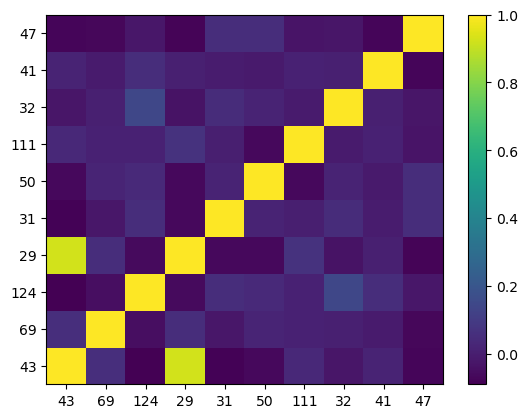

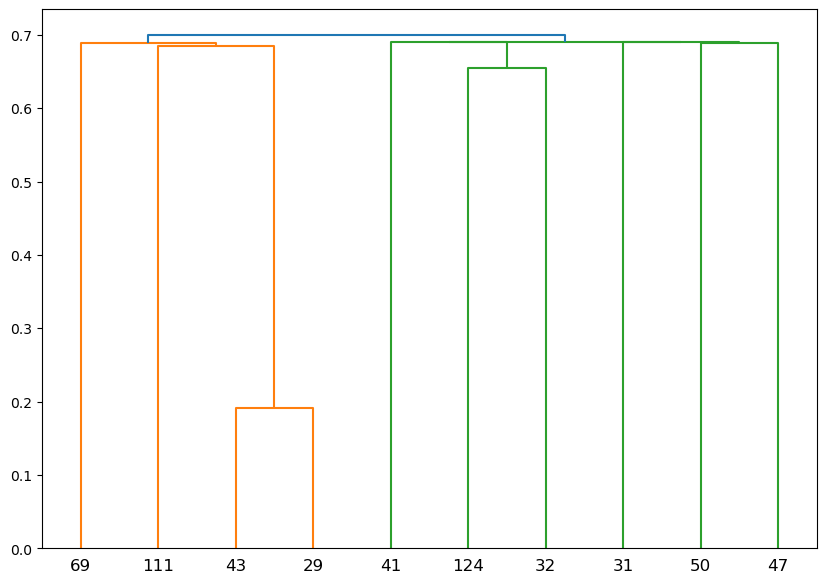

In [21]:
cov_matrix = cov_return_data[1][4132]['covariance']
corr_matrix = cov_return_data[0][4132]['correlation']
hrp = HierarchicalRiskParity(cov_matrix)
hrp.plotCorrMatrix(corr_matrix,labels= corr_matrix.columns)

# Define the distance matrix, and the cluster link
dist_matrix = hrp.correlDist(corr_matrix)
condensed_dist_matrix = ssd.squareform(dist_matrix)  # Convert to condensed form
link = sch.linkage(condensed_dist_matrix, 'single')
asset_labels = corr_matrix.columns.tolist()

plt.figure(figsize=(10, 7))
sch.dendrogram(link,
               labels = asset_labels,
           color_threshold = 0.695)  # Adjust the threshold to your needs
plt.show()

In [22]:
# Define the distance matrix, and the cluster link
dist_matrix = hrp.correlDist(corr_matrix)
condensed_dist_matrix = ssd.squareform(dist_matrix)  # Convert to condensed form
link = sch.linkage(condensed_dist_matrix, 'single')

Draw a dendogram to see the link between the assets (for the simple case, we need to set a thresh hold because this quite hard to detect a specific link), but normally when we have 10,15,20 we no need it (I will check later)


For now we only use this with only 5 assets with well structured covariance matrix (to derive the Markowitz), so we do not see so much different but when we increase to 10,15,20 we wil see it more clearly

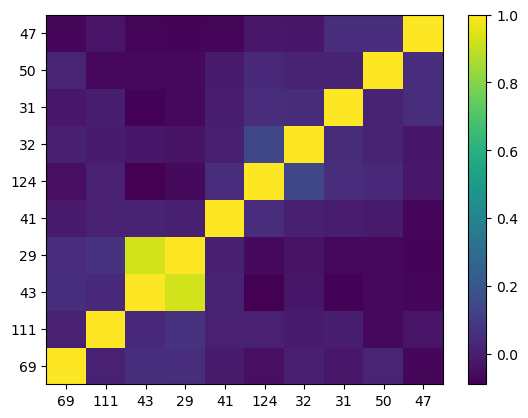

In [23]:
## Draw a graph for cluster covariance matrix 
sortIx=hrp.getQuasiDiag(link)
sortIx=corr_matrix.index[sortIx].tolist() # recover labels 
corr_cluster =corr_matrix.loc[sortIx,sortIx] # reorder 
hrp.plotCorrMatrix(corr_cluster,labels =corr_cluster.columns)